In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm.basic import LightGBMError
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from lightgbm import LGBMRegressor
import matplotlib
import optuna
import pickle

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df_train = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null 

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745305 entries, 1117957 to 1863261
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   MonsoonIntensity                 745305 non-null  int64
 1   TopographyDrainage               745305 non-null  int64
 2   RiverManagement                  745305 non-null  int64
 3   Deforestation                    745305 non-null  int64
 4   Urbanization                     745305 non-null  int64
 5   ClimateChange                    745305 non-null  int64
 6   DamsQuality                      745305 non-null  int64
 7   Siltation                        745305 non-null  int64
 8   AgriculturalPractices            745305 non-null  int64
 9   Encroachments                    745305 non-null  int64
 10  IneffectiveDisasterPreparedness  745305 non-null  int64
 11  DrainageSystems                  745305 non-null  int64
 12  CoastalVulnerability   

In [6]:
df_train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [7]:
df_train.nunique()

MonsoonIntensity                   17
TopographyDrainage                 19
RiverManagement                    17
Deforestation                      18
Urbanization                       18
ClimateChange                      18
DamsQuality                        17
Siltation                          17
AgriculturalPractices              17
Encroachments                      19
IneffectiveDisasterPreparedness    17
DrainageSystems                    18
CoastalVulnerability               18
Landslides                         17
Watersheds                         17
DeterioratingInfrastructure        18
PopulationScore                    19
WetlandLoss                        20
InadequatePlanning                 17
PoliticalFactors                   17
FloodProbability                   83
dtype: int64

In [8]:
df_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.000000,4.921450,2.056387,0.000000,3.000000,5.000000,6.000000,16.000000
TopographyDrainage,1117957.000000,4.926671,2.093879,0.000000,3.000000,5.000000,6.000000,18.000000
RiverManagement,1117957.000000,4.955322,2.072186,0.000000,4.000000,5.000000,6.000000,16.000000
Deforestation,1117957.000000,4.942240,2.051689,0.000000,4.000000,5.000000,6.000000,17.000000
Urbanization,1117957.000000,4.942517,2.083391,0.000000,3.000000,5.000000,6.000000,17.000000
ClimateChange,1117957.000000,4.934093,2.057742,0.000000,3.000000,5.000000,6.000000,17.000000
DamsQuality,1117957.000000,4.955878,2.083063,0.000000,4.000000,5.000000,6.000000,16.000000
Siltation,1117957.000000,4.927791,2.065992,0.000000,3.000000,5.000000,6.000000,16.000000
AgriculturalPractices,1117957.000000,4.942619,2.068545,0.000000,3.000000,5.000000,6.000000,16.000000
Encroachments,1117957.000000,4.949230,2.083324,0.000000,4.000000,5.000000,6.000000,18.000000


### Data Visualization¶


<Axes: xlabel='FloodProbability', ylabel='Count'>

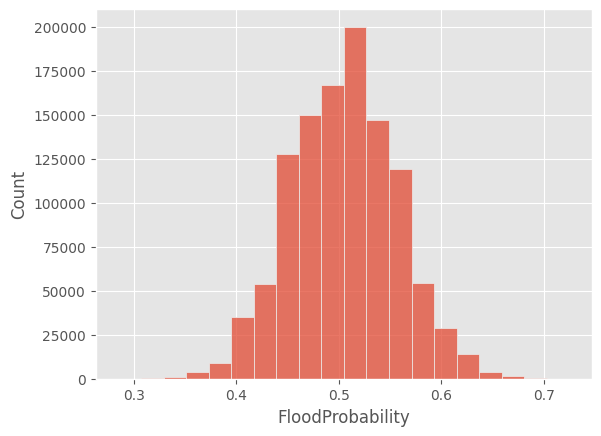

In [9]:
sns.histplot(data = df_train['FloodProbability'], bins = 20)

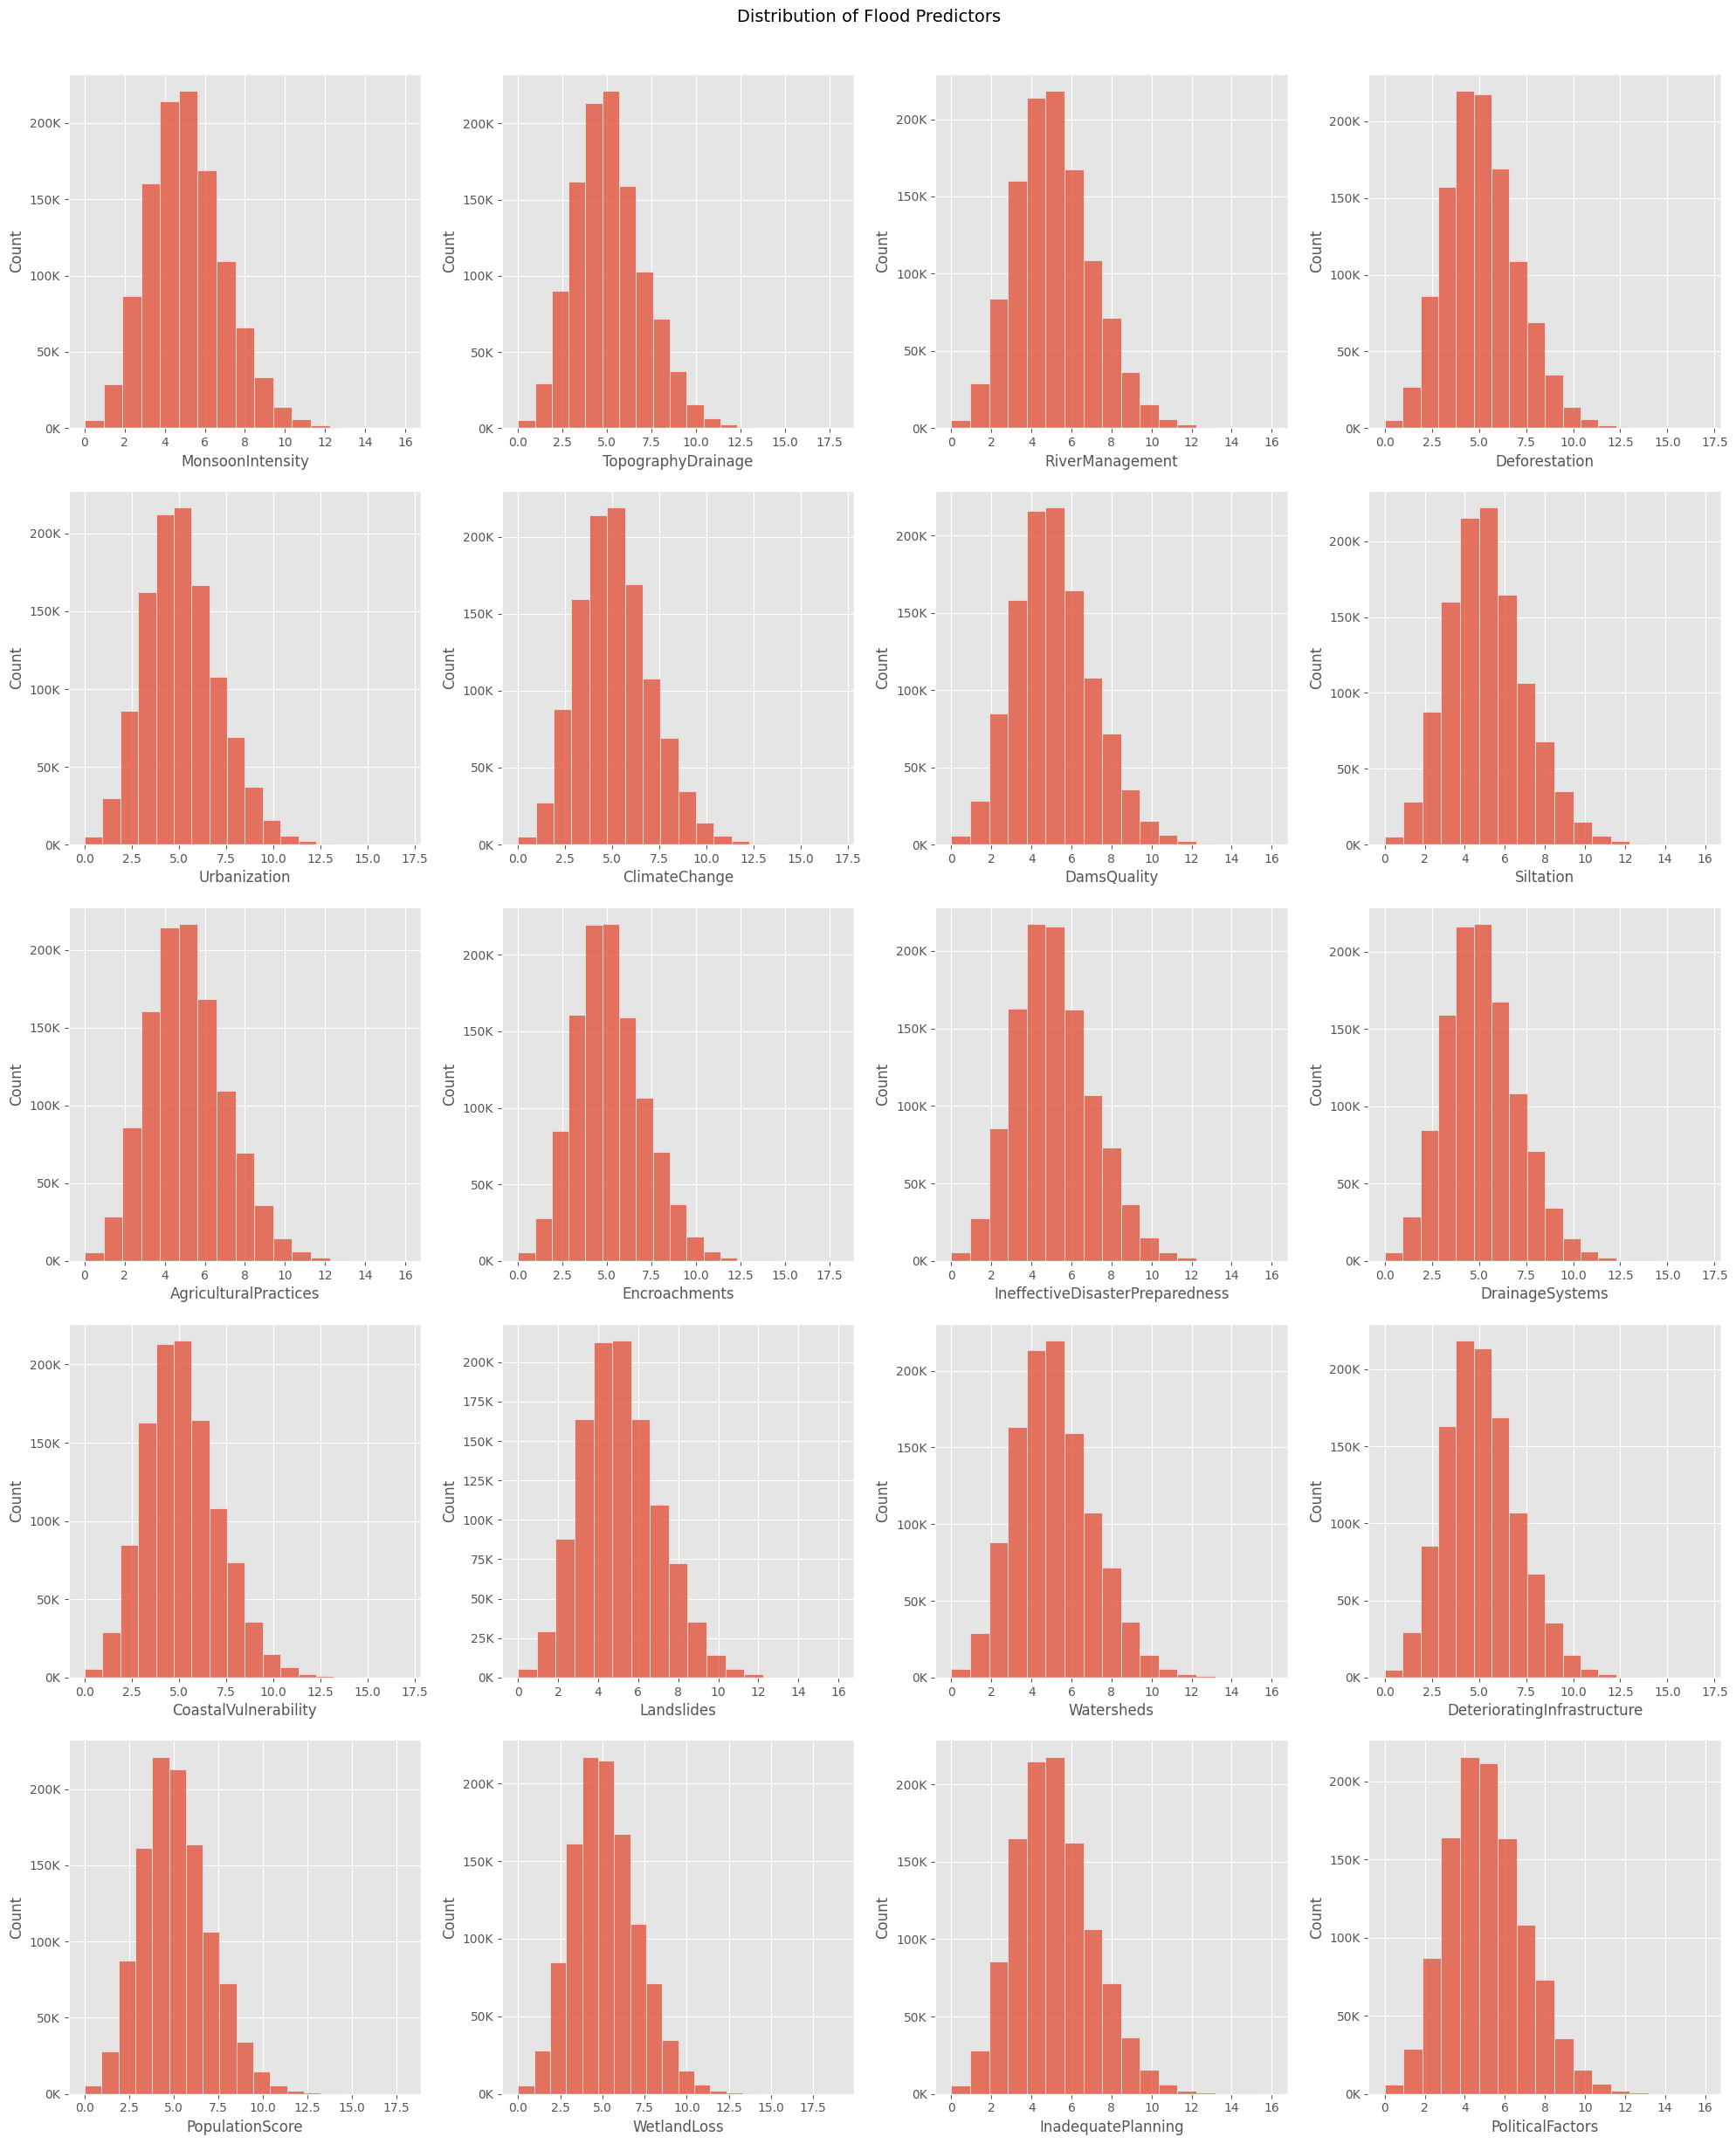

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
 
for i, column in enumerate(df_train.columns):
    if column == 'FloodProbability':
        continue
    plt.subplots_adjust(top = 0.85)
    ax = sns.histplot(data = df_train, 
                x = column, 
                bins = df_train[column].nunique(),
                ax = axes[i // 4, i % 4])
    
    ax.set_yticklabels(['{:,.0f}K'.format(ticks / 1000) for ticks in ax.get_yticks()])
fig.tight_layout(h_pad = 2)
plt.subplots_adjust(top = 0.95)
plt.suptitle('Distribution of Flood Predictors', fontsize = 14)
plt.show()

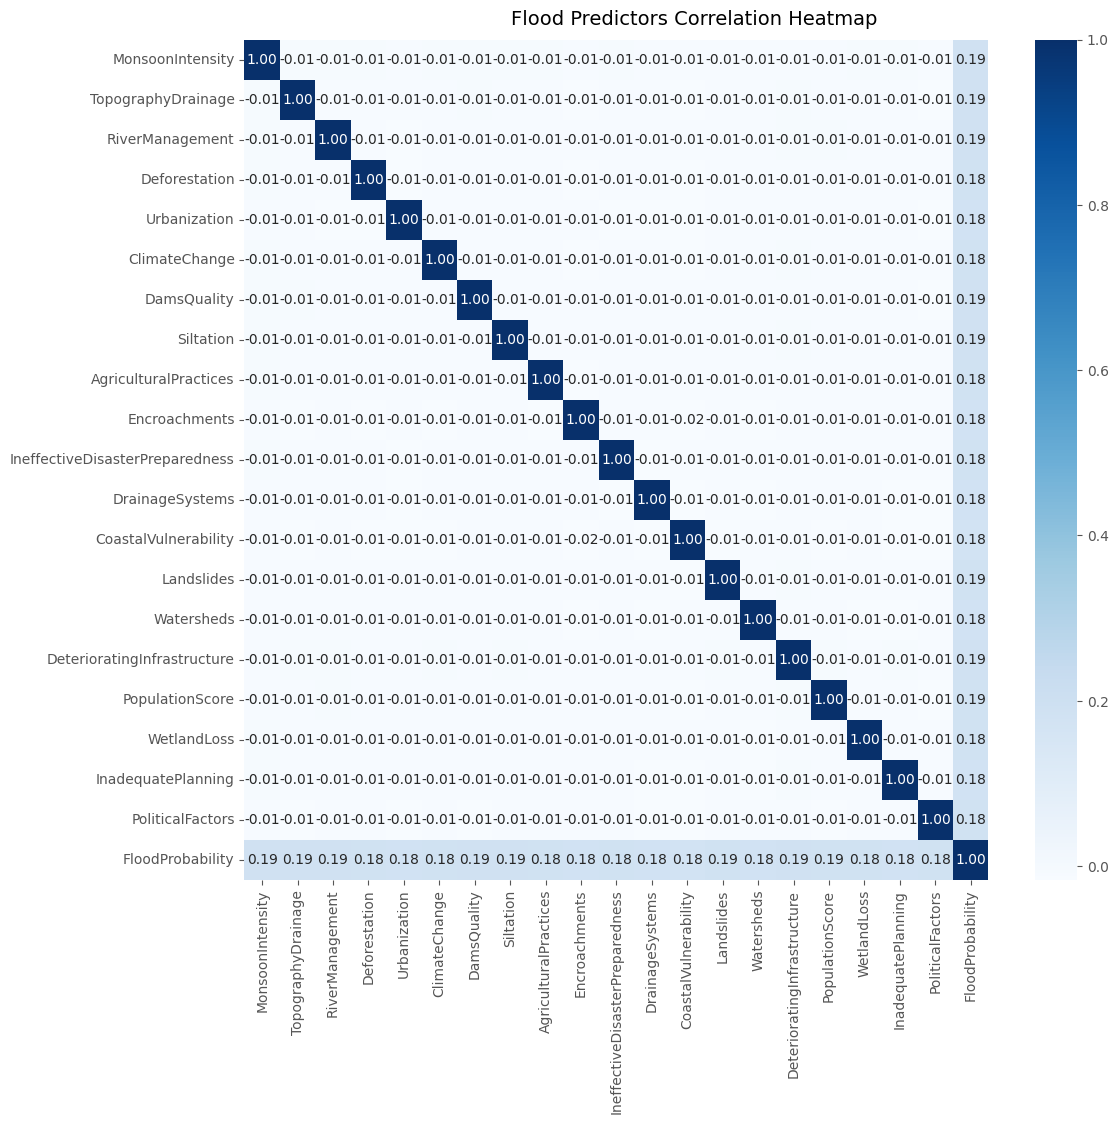

In [11]:
fig, ax = plt.subplots(figsize = (12,10))
corr = df_train.corr()
hm = sns.heatmap(corr,
                annot = True,
                ax = ax,
                cmap = 'Blues',
                fmt = '.2f')
fig.subplots_adjust(top = 0.95)
plt.suptitle('Flood Predictors Correlation Heatmap', fontsize = 14)
plt.show()

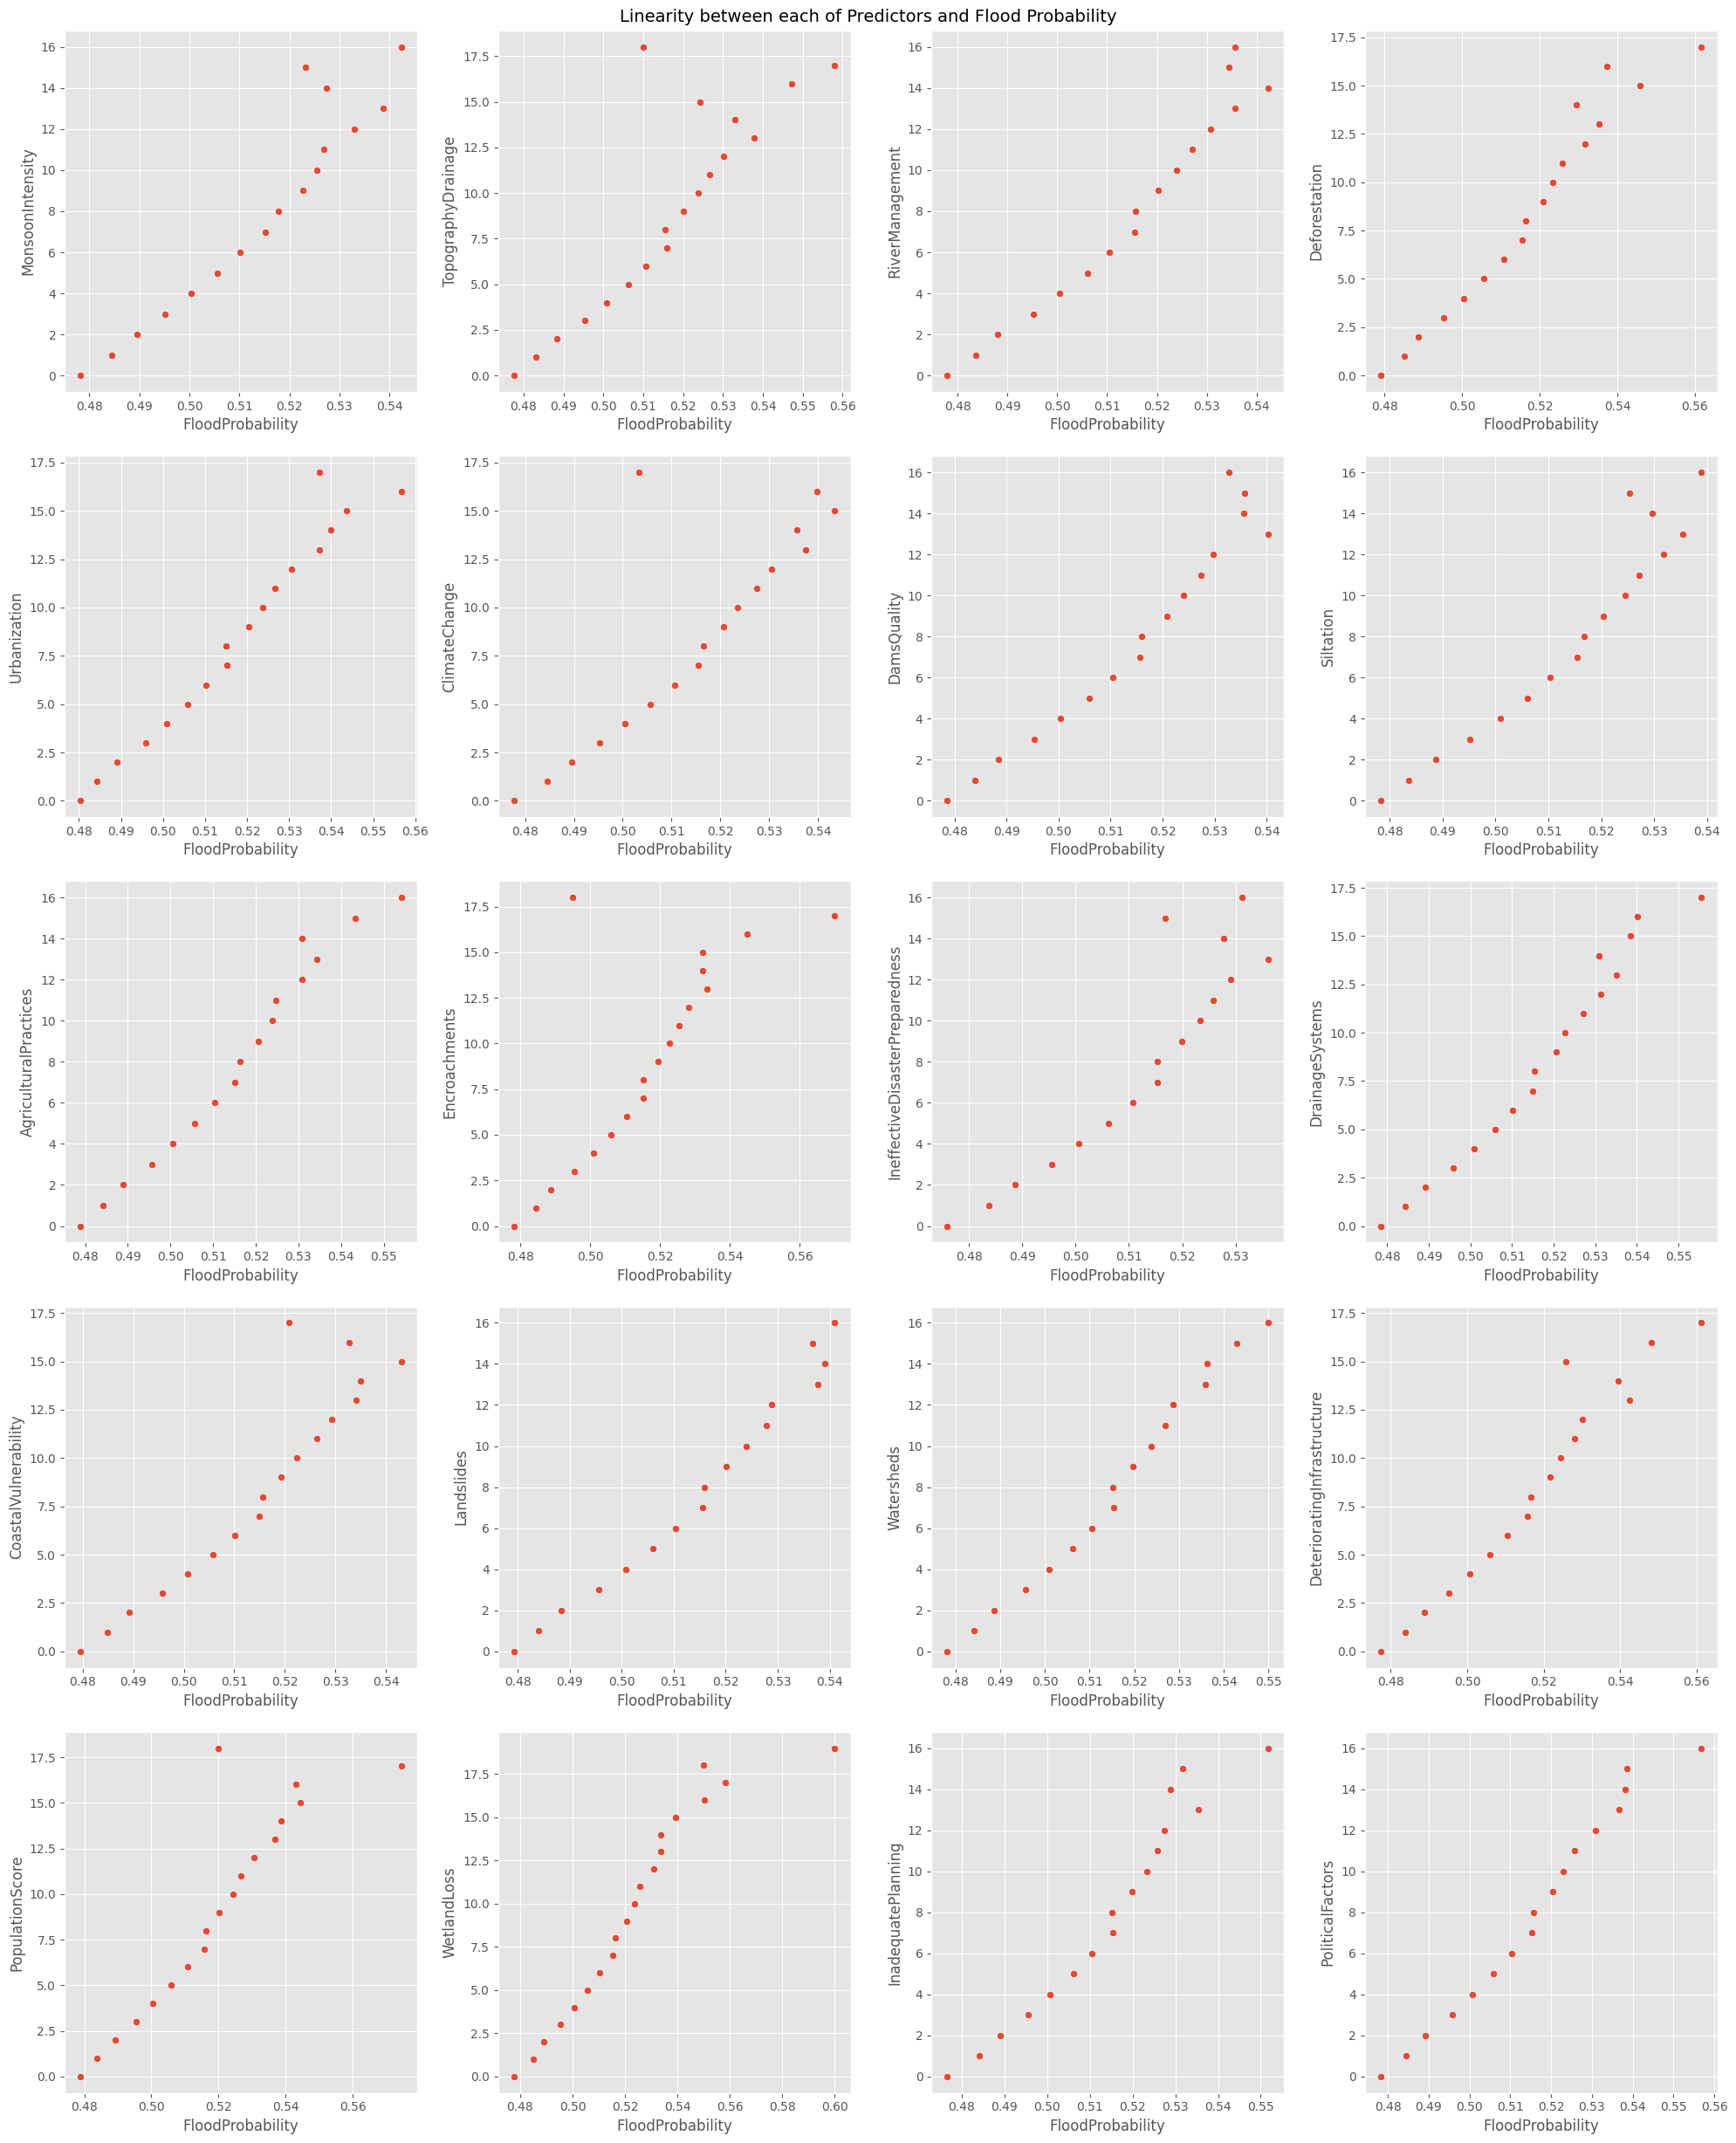

In [12]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

for i, column in enumerate(df_train.columns):
    if column == 'FloodProbability':
        continue
    temp_df = df_train[['FloodProbability', column]].groupby(column).mean().reset_index()
    plt.subplots_adjust(top = 0.85)
    ax = sns.scatterplot(data = temp_df,
                y = column,
                x = 'FloodProbability',
                ax = axes[i // 4, i % 4])

fig.tight_layout(h_pad = 2)
fig.subplots_adjust(top = 0.97)
plt.suptitle('Linearity between each of Predictors and Flood Probability', fontsize = 14)
plt.show()